# Amazon Dataset 
Description of the dataset ....

In [1]:
import os
import time
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import distanceclosure as dc
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, from_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import torch_geometric.transforms as T
from torch_geometric.datasets import Amazon
import torch_geometric.transforms.to_device
from src import add_weights_to_edges, mb_sparsify, generate_train_and_test_mask, GCN, train, test, eval_model, get_edge_idx_from_adj_matrix, get_num_edges_from_adj_matrix

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:

transform_to_device = T.Compose([T.ToDevice(device)])
dataset = Amazon(root='../data/amazon', name='Computers', transform=T.NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
data = data

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!


Dataset: AmazonComputers():
Number of graphs: 1
Number of features: 767
Number of classes: 10

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])
Number of nodes: 13752
Number of edges: 491722
Average node degree: 35.76
Has isolated nodes: True
Has self-loops: False
Is undirected: True


## Preprocessing the data
We separate the experiment into three categories of data
- The original graph
- The metric backbone of the graph with edges weighted by the inverse of their adamic-adar index
- The metric backbone of the graph with edges weighted by the inverse of their jaccard coefficient

In [4]:
from torch_geometric.transforms import RemoveDuplicatedEdges

G = to_networkx(data, to_undirected=True, node_attrs=data.node_attrs())
J = add_weights_to_edges(G, method='jaccard')
AA = add_weights_to_edges(G, method='adamic_adar')

#Using rust to compute the metric backbone
AA_mb = mb_sparsify(nx.to_numpy_array(AA))
J_mb = mb_sparsify(nx.to_numpy_array(J))

dataG = data.to(device)
data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)

print(f'Original Graph : {dataG.num_edges/2} edges')
print(f'Metric Backbone of Adamic Adar weighted graph : {data_AdamicAdar_mb.num_edges/2} edges -> {data_AdamicAdar_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')
print(f'Metric Backbone of Jaccard weighted graph : {data_Jaccard_mb.num_edges/2} edges -> {data_Jaccard_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')

/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_19879/228639859.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_19879/228639859.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)


Original Graph : 245861.0 edges
Metric Backbone of Adamic Adar weighted graph : 219625.0 edges -> 89.33% of the edges remain
Metric Backbone of Jaccard weighted graph : 142823.0 edges -> 58.09% of the edges remain


In [5]:
data_AdamicAdar_mb = transform_to_device(data_AdamicAdar_mb)
data_Jaccard_mb = transform_to_device(data_Jaccard_mb)  
dataG = transform_to_device(dataG)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
num_features = data.num_features
num_classes = dataset.num_classes


## Evaluating the model on the full graph

Epoch: 001, Loss: 2.3033, Train: 0.3806, Test: 0.3685
Epoch: 010, Loss: 2.1251, Train: 0.3812, Test: 0.3690
Epoch: 020, Loss: 1.9678, Train: 0.3812, Test: 0.3690
Epoch: 030, Loss: 1.9261, Train: 0.3812, Test: 0.3690
Epoch: 040, Loss: 1.9043, Train: 0.3812, Test: 0.3690
Epoch: 050, Loss: 1.8878, Train: 0.3812, Test: 0.3690
Epoch: 060, Loss: 1.8778, Train: 0.3812, Test: 0.3690
Epoch: 070, Loss: 1.8585, Train: 0.3812, Test: 0.3690
Epoch: 080, Loss: 1.8380, Train: 0.3812, Test: 0.3690
Epoch: 090, Loss: 1.8094, Train: 0.3812, Test: 0.3690
Epoch: 100, Loss: 1.7852, Train: 0.3812, Test: 0.3690
Epoch: 110, Loss: 1.7386, Train: 0.3812, Test: 0.3690
Epoch: 120, Loss: 1.6839, Train: 0.3813, Test: 0.3690
Epoch: 130, Loss: 1.6328, Train: 0.3813, Test: 0.3691
Epoch: 140, Loss: 1.5662, Train: 0.3870, Test: 0.3751
Epoch: 150, Loss: 1.5163, Train: 0.4196, Test: 0.4058
Epoch: 160, Loss: 1.4608, Train: 0.4855, Test: 0.4702
Epoch: 170, Loss: 1.3986, Train: 0.5333, Test: 0.5255
Epoch: 180, Loss: 1.3491, Tr

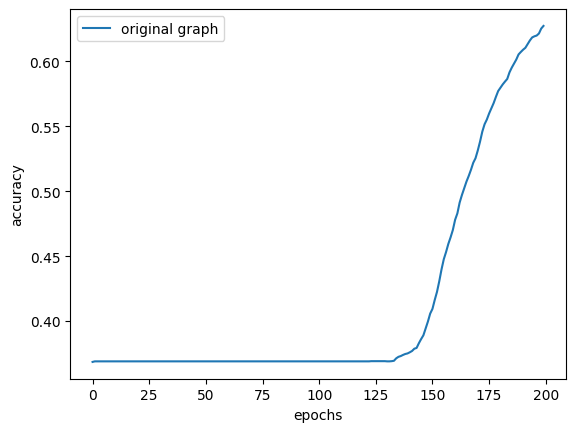

Median time per epoch: 0.127183198928833s
Overall time: 31.068662881851196s
Best validation accuracy: 0.64


In [6]:
N_EPOCHS = 200

fg_model = GCN(num_features, 16, num_classes).to(device)
fg_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
fg_optimizer = torch.optim.Adam(fg_model.parameters(), lr=0.01)  # Define optimizer.
fg_best_val_acc, fg_accs, fg_median_time_per_epoch, fg_overall_time = eval_model(fg_model, dataG, train_mask, test_mask, fg_optimizer,N_EPOCHS)
fig, ax = plt.subplots()

ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {fg_median_time_per_epoch}s")
print(f"Overall time: {fg_overall_time}s")
print(f"Best validation accuracy: {fg_best_val_acc:.2f}")


## Evaluating the model on the metric backbone of the Adamic-Adar weighted graph

In [7]:
print(f"{dataG.x.shape}")

torch.Size([13752, 767])


Epoch: 001, Loss: 2.3040, Train: 0.1024, Test: 0.1037
Epoch: 010, Loss: 2.1609, Train: 0.4066, Test: 0.3941
Epoch: 020, Loss: 1.9873, Train: 0.3812, Test: 0.3690
Epoch: 030, Loss: 1.9281, Train: 0.3812, Test: 0.3690
Epoch: 040, Loss: 1.8996, Train: 0.3812, Test: 0.3690
Epoch: 050, Loss: 1.8890, Train: 0.3812, Test: 0.3690
Epoch: 060, Loss: 1.8645, Train: 0.3812, Test: 0.3690
Epoch: 070, Loss: 1.8471, Train: 0.3812, Test: 0.3690
Epoch: 080, Loss: 1.8257, Train: 0.3812, Test: 0.3690
Epoch: 090, Loss: 1.7958, Train: 0.3812, Test: 0.3690
Epoch: 100, Loss: 1.7557, Train: 0.3812, Test: 0.3690
Epoch: 110, Loss: 1.7119, Train: 0.3812, Test: 0.3690
Epoch: 120, Loss: 1.6624, Train: 0.3813, Test: 0.3690
Epoch: 130, Loss: 1.6187, Train: 0.3837, Test: 0.3704
Epoch: 140, Loss: 1.5677, Train: 0.3967, Test: 0.3826
Epoch: 150, Loss: 1.5058, Train: 0.4346, Test: 0.4229
Epoch: 160, Loss: 1.4469, Train: 0.4795, Test: 0.4713
Epoch: 170, Loss: 1.4026, Train: 0.5201, Test: 0.5129
Epoch: 180, Loss: 1.3472, Tr

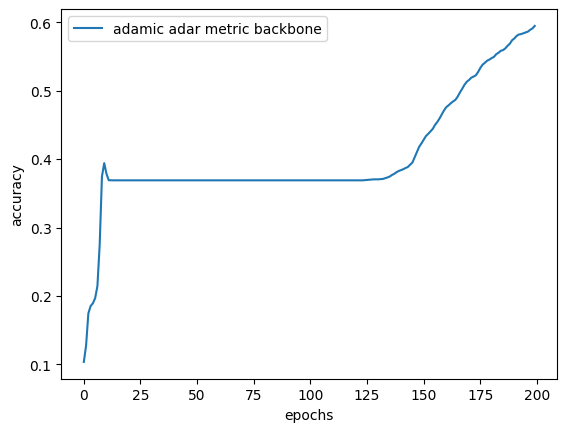

Median time per epoch: 0.12866616249084473s
Overall time: 25.815360069274902s
Best accuracy: 0.60%


In [8]:
aa_model = GCN(num_features, 16, num_classes).to(device)
aa_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
aa_optimizer = torch.optim.Adam(aa_model.parameters(), lr=0.01)  # Define optimizer.
aa_best_val_acc, aa_accs, aa_median_time_per_epoch, aa_overall_time = eval_model(aa_model, data_AdamicAdar_mb, train_mask, test_mask, aa_optimizer, N_EPOCHS)
aa_fig, aa_ax = plt.subplots()

aa_ax.plot(range(len(aa_accs)), aa_accs, label='adamic adar metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {aa_median_time_per_epoch}s")
print(f"Overall time: {aa_overall_time}s")
print(f"Best accuracy: {aa_best_val_acc:.2f}%")

## Evaluating the model on the metric backbone of the Jaccard weighted graph

Epoch: 001, Loss: 2.3033, Train: 0.1515, Test: 0.1600
Epoch: 010, Loss: 2.1617, Train: 0.1515, Test: 0.1600
Epoch: 020, Loss: 1.9974, Train: 0.3812, Test: 0.3690
Epoch: 030, Loss: 1.9014, Train: 0.3812, Test: 0.3690
Epoch: 040, Loss: 1.8870, Train: 0.3812, Test: 0.3690
Epoch: 050, Loss: 1.8662, Train: 0.3812, Test: 0.3690
Epoch: 060, Loss: 1.8507, Train: 0.3812, Test: 0.3690
Epoch: 070, Loss: 1.8294, Train: 0.3812, Test: 0.3690
Epoch: 080, Loss: 1.7992, Train: 0.3812, Test: 0.3690
Epoch: 090, Loss: 1.7623, Train: 0.3812, Test: 0.3690
Epoch: 100, Loss: 1.7219, Train: 0.3812, Test: 0.3690
Epoch: 110, Loss: 1.6694, Train: 0.3812, Test: 0.3690
Epoch: 120, Loss: 1.6068, Train: 0.3813, Test: 0.3690
Epoch: 130, Loss: 1.5534, Train: 0.3997, Test: 0.3851
Epoch: 140, Loss: 1.4959, Train: 0.4570, Test: 0.4458
Epoch: 150, Loss: 1.4531, Train: 0.5111, Test: 0.5029
Epoch: 160, Loss: 1.3969, Train: 0.5542, Test: 0.5464
Epoch: 170, Loss: 1.3488, Train: 0.5845, Test: 0.5756
Epoch: 180, Loss: 1.3022, Tr

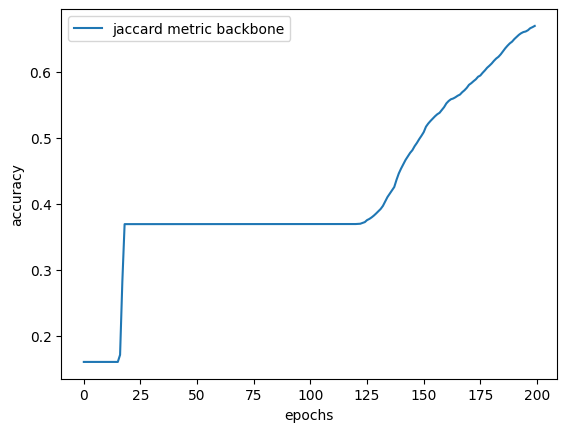

Median time per epoch: 0.03844928741455078s
Overall time: 7.82217812538147s
Best accuracy: 0.68%


In [9]:
j_model = GCN(num_features, 16, num_classes).to(device)
j_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
j_optimizer = torch.optim.Adam(j_model.parameters(), lr=0.01)  # Define optimizer.
j_best_val_acc, j_accs, j_median_time_per_epoch, j_overall_time = eval_model(j_model, data_Jaccard_mb, train_mask, test_mask, j_optimizer, N_EPOCHS)
j_fig, j_ax = plt.subplots()

j_ax.plot(range(len(j_accs)), j_accs, label='jaccard metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {j_median_time_per_epoch}s")
print(f"Overall time: {j_overall_time}s")
print(f"Best accuracy: {j_best_val_acc:.2f}%")

## Plots

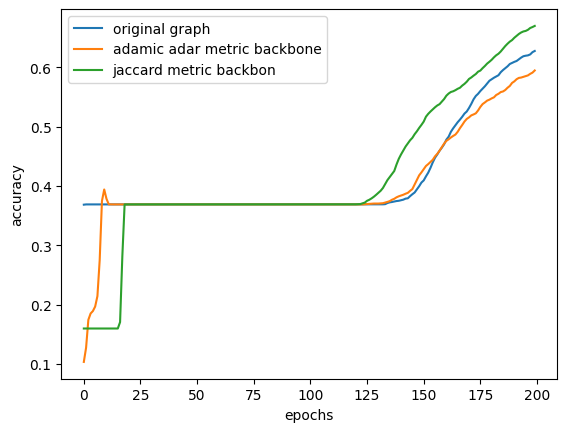

In [10]:
fig, ax = plt.subplots()
ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
ax.plot(range(len(fg_accs)), aa_accs, label='adamic adar metric backbone')
ax.plot(range(len(fg_accs)), j_accs, label='jaccard metric backbon')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()


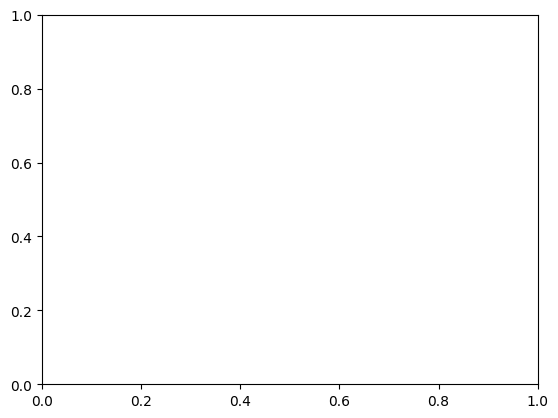

In [11]:
fig, ax = plt.subplots()
